<a href="https://colab.research.google.com/github/matheusfigueiredoo/detection-of-cyber-attacks/blob/main/%5B2%5D_multi_mqttset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras==2.12.0

In [3]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre processing data

In [4]:
train = pd.read_csv("drive/MyDrive/MQTTset/train70_augmented.csv")
test = pd.read_csv("drive/MyDrive/MQTTset/test30_augmented.csv")
train = pd.DataFrame(train)
test = pd.DataFrame(test)

# data shape
print("Train shape: ", train.shape)
print("Test shape: ", test.shape, "\n")

print("Train target:\n", train['target'].value_counts())
print("Test target:\n",test['target'].value_counts())

Train shape:  (14000000, 34)
Test shape:  (6000000, 34) 

Train target:
 target
legitimate    7000000
bruteforce    1400000
flood         1400000
slowite       1400000
dos           1400000
malformed     1400000
Name: count, dtype: int64
Test target:
 target
legitimate    3000000
dos            600000
slowite        600000
flood          600000
bruteforce     600000
malformed      600000
Name: count, dtype: int64


In [5]:
# features countais only values equal to 0
print(train['mqtt.conack.flags.reserved'].unique())
print(train['mqtt.conack.flags.sp'].unique())
print(train['mqtt.conflag.qos'].unique())
print(train['mqtt.conflag.reserved'].unique())
print(train['mqtt.conflag.retain'].unique())
print(train['mqtt.conflag.willflag'].unique())
print(train['mqtt.sub.qos'].unique())
print(train['mqtt.suback.qos'].unique())
print(train['mqtt.willmsg'].unique())
print(train['mqtt.willmsg_len'].unique())
print(train['mqtt.willtopic'].unique())
print(train['mqtt.willtopic_len'].unique())

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [6]:
# columns_0 are columns with values equal to 0
columns_0 = ['mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conflag.qos',
           'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.willflag',
           'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.willmsg', 'mqtt.willmsg_len',
           'mqtt.willtopic', 'mqtt.willtopic_len']

train = train.drop(columns_0, axis=1)
test = test.drop(columns_0, axis=1)

# new data shape
print(train.shape)
print(test.shape)

(14000000, 22)
(6000000, 22)


In [ ]:
# data balancing

# train
x = []
for i in train.index:
    if train['target'][i] == 'legitimate':
        x.append(i)

x = x[:5600000]
train = train.drop(x)

# ------------------------------------------------------------------------------

#test
x = []
for i in test.index:
    if test['target'][i] == 'legitimate':
        x.append(i)

x = x[:2400000]
test = test.drop(x)


# new data shape
print(train['target'].value_counts())
print(test['target'].value_counts())

In [ ]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

# features and target
train['tcp.flags'] = label.fit_transform(train['tcp.flags'])
train['mqtt.conack.flags'] = label.fit_transform(train['mqtt.conack.flags'])
train['mqtt.hdrflags'] = label.fit_transform(train['mqtt.hdrflags'])
train['mqtt.protoname'] = label.fit_transform(train['mqtt.protoname'])
train['mqtt.msg'] = label.fit_transform(train['mqtt.msg'])
train['mqtt.conflags'] = label.fit_transform(train['mqtt.conflags'])
train['target'] = label.fit_transform(train['target'])

test['tcp.flags'] = label.fit_transform(test['tcp.flags'])
test['mqtt.conack.flags'] = label.fit_transform(test['mqtt.conack.flags'])
test['mqtt.hdrflags'] = label.fit_transform(test['mqtt.hdrflags'])
test['mqtt.protoname'] = label.fit_transform(test['mqtt.protoname'])
test['mqtt.msg'] = label.fit_transform(test['mqtt.msg'])
test['mqtt.conflags'] = label.fit_transform(test['mqtt.conflags'])
test['target'] = label.fit_transform(test['target'])

In [9]:
X_train = train.iloc[:,:-1]
y_train = train['target']
X_test = test.iloc[:,:-1]
y_test = test['target']

print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

# convert to numpy
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Gaussian Naive Bayes

Accuracy train:  0.5298892857142857
Cross-validation scores: [0.52995833 0.5303256  0.52964464 0.52976488 0.52977083]
Average cross-validation score: 0.53 

Accuracy test:  0.5298541666666666 

Classification report: 
              precision    recall  f1-score   support

           0       0.28      1.00      0.44    600000
           1       0.96      0.72      0.82    600000
           2       0.98      0.49      0.65    600000
           3       0.76      0.62      0.68    600000
           4       1.00      0.15      0.26    600000
           5       0.98      0.21      0.34    600000

    accuracy                           0.53   3600000
   macro avg       0.83      0.53      0.53   3600000
weighted avg       0.83      0.53      0.53   3600000
 

Confusion matrix:
 [[600000      0      0      0      0      0]
 [169519 430130      0    206    145      0]
 [303600      0 292800   3600      0      0]
 [222406      0   4714 372880      0      0]
 [439260  16980   1680  51420  88440  

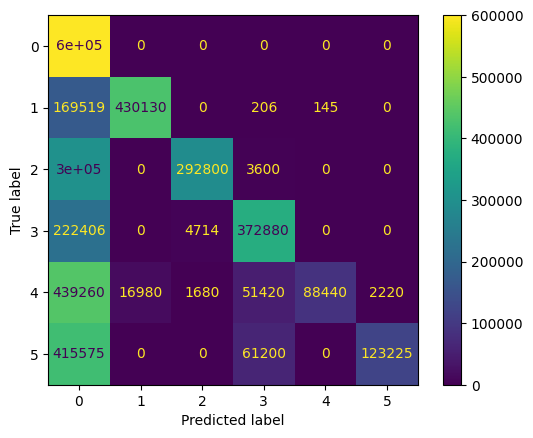

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print("Accuracy train: ", nb.score(X_train, y_train))
# cross validation
scores_nb = cross_val_score(nb, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores_nb))
print("Average cross-validation score: {:.2f}".format(scores_nb.mean()),"\n")

print("Accuracy test: ", nb.score(X_test, y_test), "\n")

# classification report
predict_nb = nb.predict(X_test)
print("Classification report: ")
print(classification_report(y_test, predict_nb), "\n")

# confusion matrix
matrix_nb = confusion_matrix(y_test, predict_nb)
print("Confusion matrix:\n", matrix_nb, "\n")
cm_nb = confusion_matrix(y_test, predict_nb, labels=nb.classes_)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb.classes_)
disp_nb.plot()
plt.show()

# Gradient Boosting

Accuracy train:  0.8640561904761904
Cross-validation scores: [0.8636244  0.8641006  0.86455298 0.86451607 0.86429881]
Average cross-validation score: 0.86 

Accuracy test:  0.8644205555555555 

Classification report: 
              precision    recall  f1-score   support

           0       0.72      0.89      0.80    600000
           1       0.91      0.88      0.89    600000
           2       0.87      0.88      0.88    600000
           3       0.84      0.91      0.87    600000
           4       0.88      0.63      0.74    600000
           5       1.00      1.00      1.00    600000

    accuracy                           0.86   3600000
   macro avg       0.87      0.86      0.86   3600000
weighted avg       0.87      0.86      0.86   3600000
 

Confusion matrix:
 [[534296  26188   1883    515  37118      0]
 [  9815 527350  19187  33029  10619      0]
 [  1200   4800 526800  63600   3600      0]
 [    80   4384  50573 544268    695      0]
 [196020  16980   5040   2760 379200  

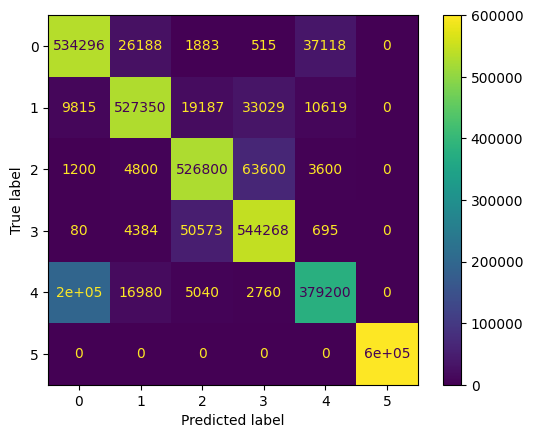

In [10]:
# gradient boosting

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
print("Accuracy train: ", gb.score(X_train, y_train))
# cross validation
scores_gb = cross_val_score(gb, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores_gb))
print("Average cross-validation score: {:.2f}".format(scores_gb.mean()),"\n")

print("Accuracy test: ", gb.score(X_test, y_test), "\n")

# classification report
predict_gb = gb.predict(X_test)
print("Classification report: ")
print(classification_report(y_test, predict_gb), "\n")

# confusion matrix
matrix_gb = confusion_matrix(y_test, predict_gb)
print("Confusion matrix:\n", matrix_gb, "\n")
cm_gb = confusion_matrix(y_test, predict_gb, labels=gb.classes_)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=gb.classes_)
disp_gb.plot()
plt.show()

# Sequential neural network

In [ ]:
# sequential neural network

model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(30, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal'))
model.add(Dense(2,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=2,epochs=200,batch_size=1000)

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\n")
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, "\n")

print("Classification report:")
print(classification_report(y_test, y_pred), "\n")

# confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix, "\n")

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe ' + str(i) for i in range(conf_matrix.shape[0])],
            yticklabels=['Classe ' + str(i) for i in range(conf_matrix.shape[0])])
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

print("\n")

Epoch 1/200
14000/14000 - 43s - loss: 0.2457 - accuracy: 0.8493 - val_loss: 0.2250 - val_accuracy: 0.8586 - 43s/epoch - 3ms/step
Epoch 2/200
14000/14000 - 40s - loss: 0.2233 - accuracy: 0.8661 - val_loss: 0.2144 - val_accuracy: 0.8760 - 40s/epoch - 3ms/step
Epoch 3/200
14000/14000 - 39s - loss: 0.2104 - accuracy: 0.8811 - val_loss: 0.2021 - val_accuracy: 0.9042 - 39s/epoch - 3ms/step
Epoch 4/200
14000/14000 - 39s - loss: 0.1998 - accuracy: 0.8965 - val_loss: 0.1883 - val_accuracy: 0.9074 - 39s/epoch - 3ms/step
Epoch 5/200
14000/14000 - 41s - loss: 0.1863 - accuracy: 0.9125 - val_loss: 0.1782 - val_accuracy: 0.9303 - 41s/epoch - 3ms/step
Epoch 6/200
14000/14000 - 41s - loss: 0.1797 - accuracy: 0.9182 - val_loss: 0.1742 - val_accuracy: 0.9160 - 41s/epoch - 3ms/step
Epoch 7/200
14000/14000 - 41s - loss: 0.1732 - accuracy: 0.9198 - val_loss: 0.1670 - val_accuracy: 0.9305 - 41s/epoch - 3ms/step
Epoch 8/200
14000/14000 - 41s - loss: 0.1716 - accuracy: 0.9213 - val_loss: 0.1717 - val_accuracy

NameError: name 'sns' is not defined

<Figure size 500x500 with 0 Axes>